### Introduction
Model of electric engine. 
1000 - 10000 RPMs.

Differential equation describing the system.

$$J\frac{d\omega}{dt} = M_e - M_0 - M_{LOAD}$$
where:
- $M_e$: electromagnetic moment
- $M_0$: braking moment
- $M_{LOAD}$: load moment
- $I$: moment of inertia

Transformation to differential form using the Eulerian method.
$$I\frac{d\omega(t+\Delta t) - \omega (t)}{\Delta t} = M_e(t)-M_0-M_{LOAD}(t)$$
$$\omega (t+\Delta t) = \omega(t) + \frac{\Delta t}{I}(M_e(t)- M_0-M_{LOAD}(t))$$

What about $M_e(t)$?
$$U_{PI}(t) = Kp \cdot e(t) + Ki \sum^t_{k=0}e(k)\Delta t$$
$$M_e(t) = U_{PI} * const$$
$$e(t) = \omega_{ref} - \omega(t)$$

### Defined Parameters

In [962]:
# Parameters of simulation
referencedRevolutionsPerMinute = 3000

# Simulation time parameters
timeOfSimulation = 1000
timeOfSample = 0.1

# Parameters of crankshaft
brakingMoment = 0.2
loadMoment = 5
momentOfInertia = 1.2
constantOfElectromagneticMoment = 0.4 #! dostosowac

# Parameters of PI regulator
Kp = 0.007
Ki = 0.00015
Kd = 0.0015

# Constraints
Umax = 24
Umin = 0


# Lists of measured values
# TODO: Think about initalizing first elements here in list
timeOfSimulationList = [0.0]
loadMomentList = [0.0] 
electromagneticMomentList = [0.0]
adjustmentErrors = [referencedRevolutionsPerMinute]
voltagesList = [0.0]
revolutionsList = [0]

### Calculations

In [963]:
def calculateNumberOfIterations(timeOfSimulation: int, timeOfSample: float) -> int:
    """ This function calculates number of iterations for simulation of process

        @Parameters:
        - timeOfSimulation (int): total time of simulation in seconds
        - timeOfSample (float): time at which we repeat the measurement in seconds

        @Return:
        - int: number of iterations
    """
    return int(timeOfSimulation / timeOfSample) + 1

In [964]:
def calculateAdjustmentError(referencedRevolutionsPerMinute: float, currentRevolutionsPerMinute: float) -> float:
    # TODO Floats or Integers???
    """ This function calculates adjustment error which is difference between referenced value and current one

        @Parameters:
        - referencedRevolutionsPerMinute (float): set value to be obtained by regulator
        - currentRevolutionsPerMinute (float): current value

        @Return:
        - float: error
    """
    return referencedRevolutionsPerMinute - currentRevolutionsPerMinute

In [965]:
def calculateVoltageOfRegulator(errorList: list[float], iteration: int) -> float:
    """
    This function calculates current voltage of regulator using PID control.

    @Parameters:
    - errorList (list[float]): list of errors at the moment and before
    - iteration (int): information about current simulation iteration

    @Return:
    - float: current voltage of regulator
    """
    # Składnik proporcjonalny
    proportional = Kp * errorList[iteration]

    # Składnik całkowy
    integral = Ki * sum(errorList) * timeOfSample

    # Składnik różniczkowy
    if iteration > 0:  # Różniczkowanie możliwe od drugiej iteracji
        derivative = (errorList[iteration] - errorList[iteration - 1]) / timeOfSample
    else:
        derivative = 0.0  # Na pierwszej iteracji brak różniczkowego wkładu

    derivative_term = Kd * derivative

    # Suma wkładów regulatora
    voltage = proportional + integral + derivative_term


    return voltage


In [966]:
def calculateElectromagneticMoment(constant : float, currentVoltage : float) -> float:
    """ This function calculates current electromagnetic moment based on voltage of regulator

        @Parameters:
        - constant (float): used to scale moment 
        - currentVoltageOfRegulator (float): voltage of regulator at the moment

        @Return
        - float: current electromagnetic moment
    """
    return constant * currentVoltage

In [967]:
def calculateNormalizedVoltage(voltgeOfRegulator : float) -> float:
    """ This function calculates normalized voltage based on predefined constraints <0;24> [V]

    @Parameters:
    - voltageOfRegulator (float): current voltage of regulator

    @Returns:
    - float: normalized voltage used to create electromagnetic moment
    """
    return max(Umin, min(Umax, voltgeOfRegulator))

In [968]:
def calculateRevoltions(revolutionsList, electromagneticMomentList):
    omega = revolutionsList[-1] *(2*3.14/60)
    acceleration = (
        electromagneticMomentList[-1] - loadMoment - brakingMoment) / momentOfInertia
    new_omega=omega+timeOfSample*acceleration

    return new_omega * (60 / (2 * 3.14))

### Simulation

In [969]:
for i in range(calculateNumberOfIterations(timeOfSimulation, timeOfSample)):
    # Update simulation time
    timeOfSimulationList.append(timeOfSimulationList[-1] + timeOfSample)


    # Calculate normalized voltage
    voltage = calculateNormalizedVoltage(
        calculateVoltageOfRegulator(adjustmentErrors, -1))
    voltagesList.append(voltage)

    # Calculate electromagnetic moment
    electromagneticMoment = calculateElectromagneticMoment(
        constantOfElectromagneticMoment, voltagesList[-1])
    electromagneticMomentList.append(electromagneticMoment)

    # Calculate revolutions and update revolutions list
    revolutions = calculateRevoltions(
        revolutionsList, electromagneticMomentList)
    revolutionsList.append(revolutions)
    #print(f"Step {i}: Referenced RPM = {referencedRevolutionsPerMinute}, Current RPM = {revolutionsList[-1]}, Current Moment = {electromagneticMomentList[-1]}")

        # Calculate adjustment error
    adjustmentError = calculateAdjustmentError(
        referencedRevolutionsPerMinute, revolutionsList[-1])
    adjustmentErrors.append(adjustmentError)
    

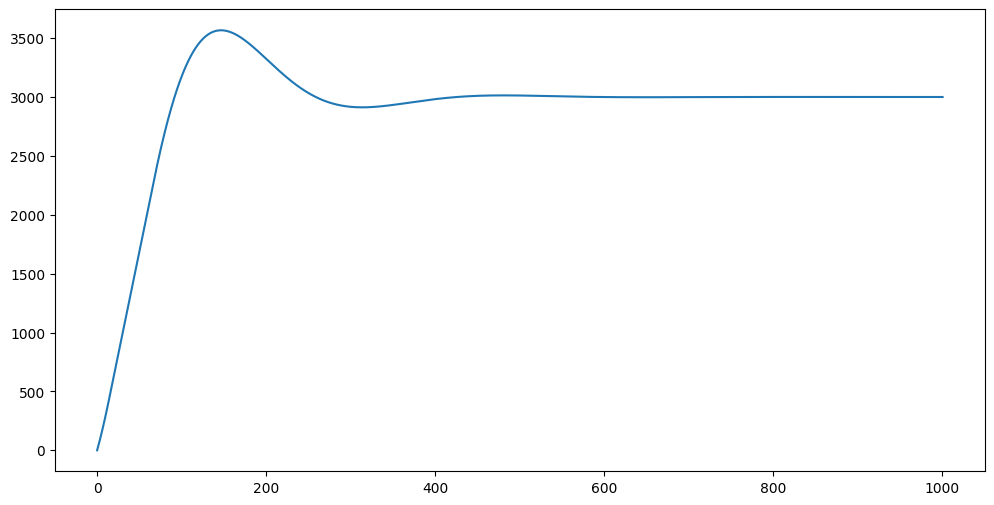

In [970]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(timeOfSimulationList, revolutionsList)

In [971]:
print(voltagesList[:20])
print(electromagneticMomentList[:20])
print(timeOfSimulationList[:20])
print(revolutionsList[:20])

[0.0, 21.045, 21.072026855095544, 21.09895489860239, 21.125784222164008, 21.152514917691146, 21.179147077360813, 21.205680793615244, 21.232116159160856, 21.25845326696723, 21.284692210266076, 21.31083308255019, 21.336875977572454, 21.36282098934477, 21.388668212137073, 21.414417740476274, 21.440069669145267, 21.46562409318186, 21.491081107877797, 21.51644080877772]
[0.0, 8.418000000000001, 8.428810742038218, 8.439581959440956, 8.450313688865604, 8.461005967076458, 8.471658830944326, 8.482272317446098, 8.492846463664343, 8.503381306786892, 8.51387688410643, 8.524333233020077, 8.534750391028982, 8.545128395737908, 8.55546728485483, 8.56576709619051, 8.576027867658107, 8.586249637272743, 8.59643244315112, 8.606576323511089]
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006]
[0